In [1]:
# import all libraries

import pandas as pd
import numpy as np


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")   

import matplotlib.pyplot as plt
import seaborn as sns

# For time stamps
from datetime import datetime

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.


import statsmodels.graphics.tsaplots as sgt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [2]:
# import data

data= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [4]:
# make close stationary using first order differencing

data['Close First Difference'] = data['Close'] - data['Close'].shift(1)

# drop the datapoint with null Value

data.dropna(inplace=True)
print(data.shape)
data.head()

(299, 7)


,id,Date,Open,Close,Volume,Strategy,Close First Difference
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,-1.166647
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,-3.302500
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,1.740512
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,-6.596626
5,5,2015-07-06,51.374399,58.494017,590857400,Buy,-7.790701


<AxesSubplot:ylabel='Density'>

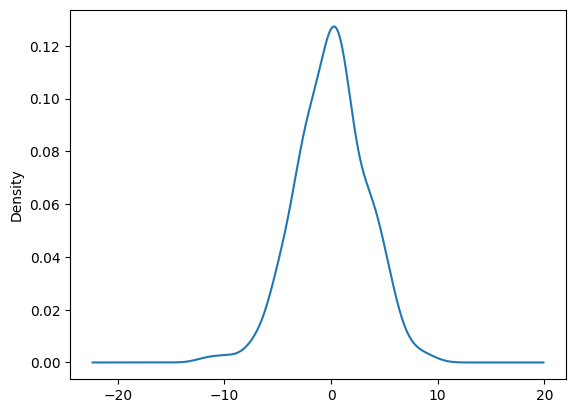

In [7]:
#Distribution of the dataset
close_price = data['Close First Difference']
close_price.plot(kind='kde')

#### SPLIT TRAIN into Train and Validation

In [16]:
# select first 0.80 of data

X_train = data.iloc[:int(data.shape[0]*0.80)]
Y_train=X_train[['Strategy','Close','Close First Difference']]

# select last 0.20 of data

X_validation = data.iloc[int(data.shape[0]*0.80):]
Y_validation=X_validation[['Strategy','Close','Close First Difference']]


In [17]:
# print shapes
print(X_train.shape)
print(X_validation.shape)

print(Y_train.shape)
print(Y_validation.shape)

(239, 7)
(60, 7)
(239, 3)
(60, 3)


# model training

In [18]:
# single exponential smoothening


df= X_train[['Close','Date']]


#### Exponential smoothening on non stationary data point

#### Single Exponential Smoothening

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alpha_value=0.5

model1 = SimpleExpSmoothing(df['Close'])

model1_fit = model1.fit(smoothing_level=alpha_value)
forecast = model1_fit.forecast(steps=len(X_validation))


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:207: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [19]:
forecast.head()

239    73.065143
240    73.065143
241    73.065143
242    73.065143
243    73.065143
dtype: float64

In [20]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close'], forecast))



Mean Squared Error: 76.53110489102022
Mean Absolute Error: 8.054474602856907


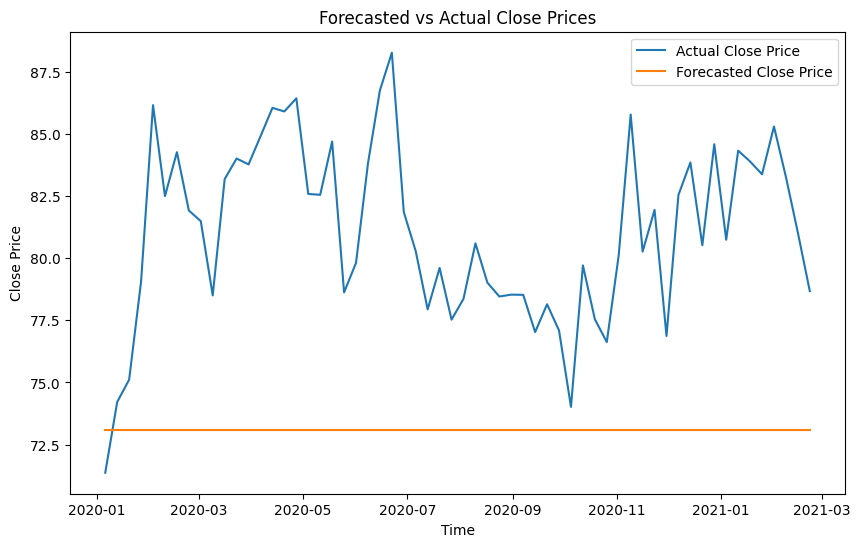

In [21]:
# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()


#### Double Exponential Smoothening

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

alpha_value = 0.9
beta_value = 0.6

model = ExponentialSmoothing(df['Close'], trend='add')
model_fit = model.fit(smoothing_level=alpha_value, smoothing_slope=beta_value)

# Generate forecasts
forecast = model_fit.forecast(steps=len(X_validation))


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
forecast.head()

239    70.604360
240    69.622789
241    68.641217
242    67.659646
243    66.678075
dtype: float64

Mean Squared Error: 1856.9599434177496
Mean Absolute Error: 39.41496579074413


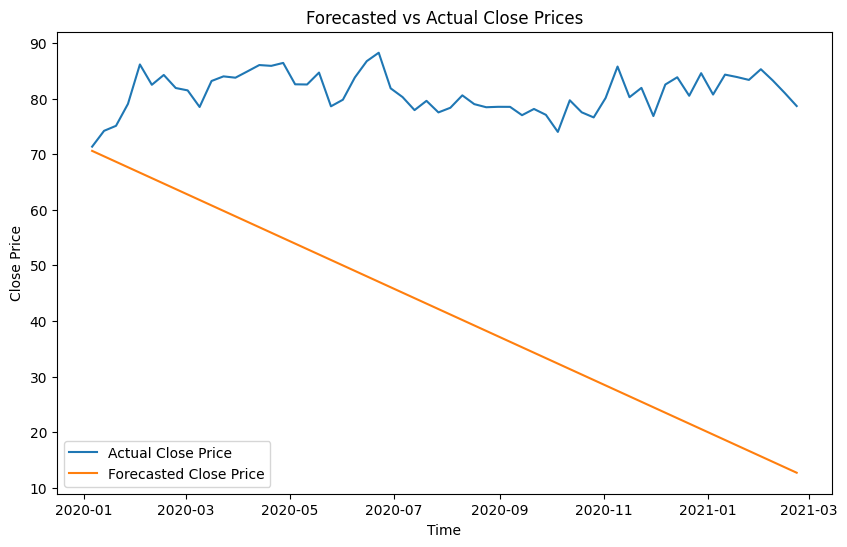

In [25]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close'], forecast))

# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()


#### Triple Exponential Smoothening


In [27]:
# triple exponential smoothening

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Specify your alpha, beta, and gamma values
alpha_value = 0.9
beta_value = 0.9
gamma_value = 0.3

# Initialize the ExponentialSmoothing model with your parameter values
model = ExponentialSmoothing(df['Close'], trend='add', 
                             seasonal='add', 
                             seasonal_periods=12, 
                             initialization_method="estimated")
model_fit = model.fit(
    # smoothing_level=alpha_value, smoothing_slope=beta_value, smoothing_seasonal=gamma_value
    )

# Generate forecasts
forecast = model_fit.forecast(steps=len(X_validation))

c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
model_fit.model.params


{'smoothing_level': 0.9014916795608573,
 'smoothing_trend': 2.2962415126758776e-08,
 'smoothing_seasonal': 2.538511689079746e-10,
 'damping_trend': nan,
 'initial_level': 72.70752314556802,
 'initial_trend': -0.010914696340173623,
 'initial_seasons': array([1.43217967, 1.49735106, 0.97139424, 1.32575865, 1.09086957,
        0.51510486, 0.72392673, 1.16316737, 1.68847394, 1.22307881,
        1.78905429, 0.65550701]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Mean Squared Error: 115.39309401518709
Mean Absolute Error: 10.12258741460901


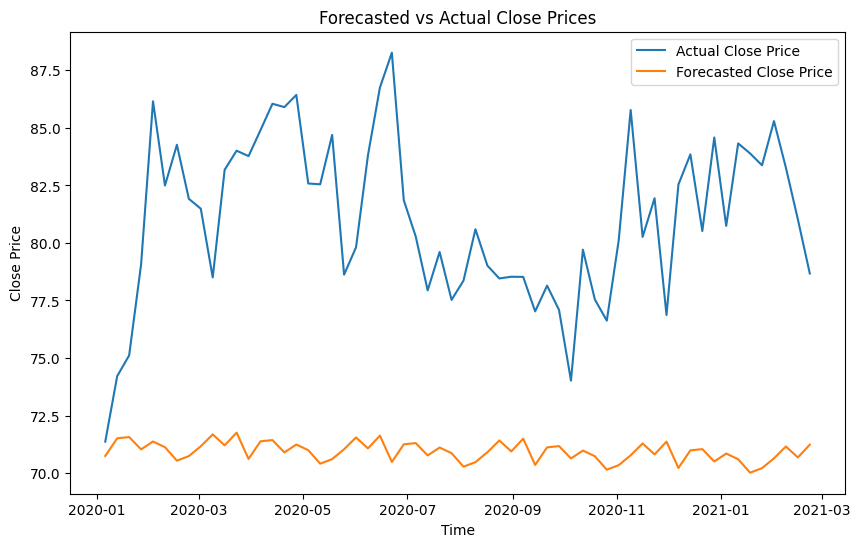

In [28]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close'], forecast))

# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()


#### Exponential smoothening on stationary data point

#### Single Exponential Smoothening

In [30]:
# single exponential smoothening

df= X_train[['Close First Difference','Date']]
df.head()


,Close First Difference,Date
1,-1.166647,2015-06-08
2,-3.302500,2015-06-15
3,1.740512,2015-06-22
4,-6.596626,2015-06-29
5,-7.790701,2015-07-06


In [33]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alpha_value=0.4

model1 = SimpleExpSmoothing(df['Close First Difference'])

model1_fit = model1.fit(smoothing_level=alpha_value)
forecast = model1_fit.predict(start=len(X_train),end=len(X_train)+len(X_validation)-1)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:207: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error: 11.810380137800696
Mean Absolute Error: 2.7656264321353223


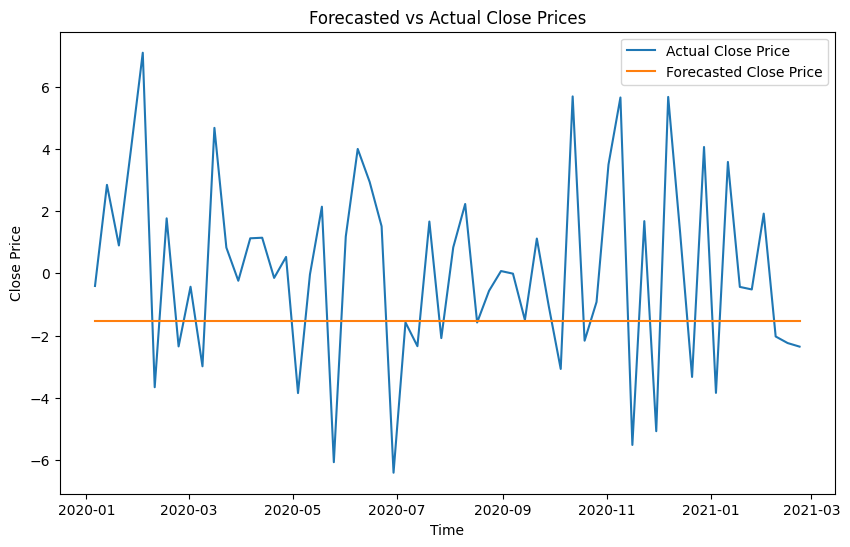

In [34]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close First Difference'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close First Difference'], forecast))


# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close First Difference'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()



#### Double Exponential Smoothening


In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

alpha_value = 0.2
beta_value = 0.6

model = ExponentialSmoothing(df['Close First Difference'], trend='add')
model_fit = model.fit(smoothing_level=alpha_value, smoothing_slope=beta_value)

# Generate forecasts
forecast = model_fit.forecast(steps=len(X_validation))


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error: 14.161401946419712
Mean Absolute Error: 3.0891596058985615


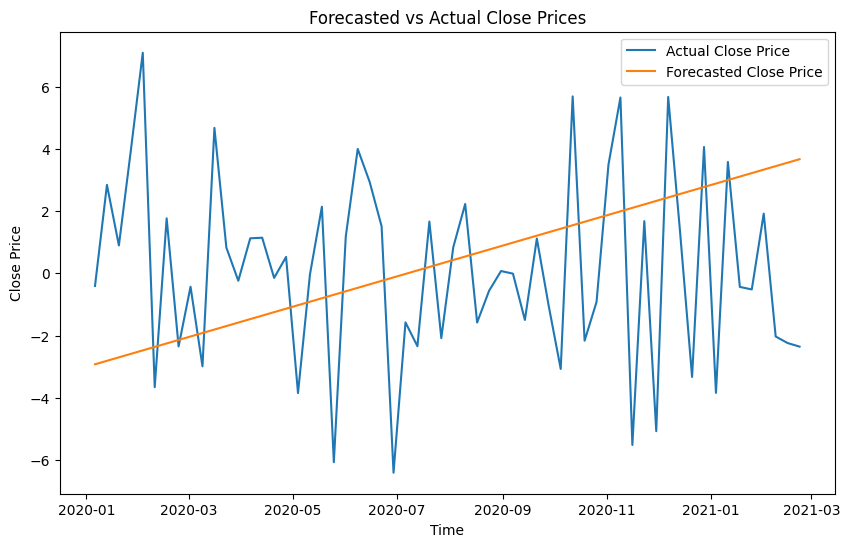

In [36]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close First Difference'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close First Difference'], forecast))


# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close First Difference'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()



#### Triple Exponential Smoothening


In [37]:
# triple exponential smoothening

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Specify your alpha, beta, and gamma values
alpha_value = 1.4901161193847656e-08
beta_value = 9.587630767616173e-09
gamma_value = 1.10644265

# Initialize the ExponentialSmoothing model with your parameter values
model = ExponentialSmoothing(df['Close First Difference'], trend='add', 
                             seasonal='add', 
                             seasonal_periods=12, 
                             initialization_method="estimated")
model_fit = model.fit(
    # smoothing_level=alpha_value, smoothing_slope=beta_value, smoothing_seasonal=gamma_value
    )

# Generate forecasts
forecast = model_fit.forecast(steps=len(X_validation))

c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error: 9.845619258136333
Mean Absolute Error: 2.4810197823368343
Root Mean Squared Error (RMSE): 3.137772977469264


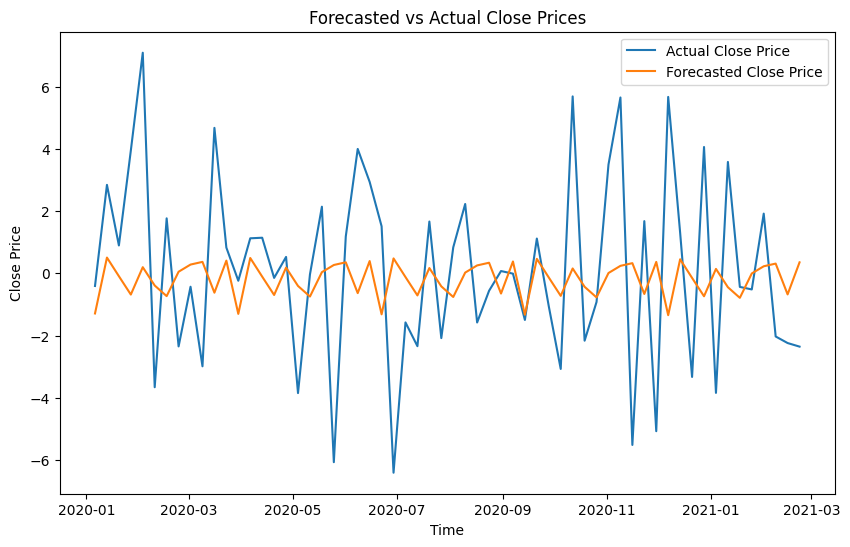

In [40]:
# Find Error and Plot

print('Mean Squared Error:', mean_squared_error(X_validation['Close First Difference'], forecast))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close First Difference'], forecast))
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(X_validation['Close First Difference'], forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")




# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['Date'], X_validation['Close First Difference'], label='Actual Close Price')
plt.plot(X_validation['Date'], forecast, label='Forecasted Close Price')
plt.title("Forecasted vs Actual Close Prices")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()



In [41]:
# get forcasted_close from forecast of test 

# Extract the last observed 'Close' value from your validation data
last_close_value = Y_validation['Close'].iloc[-1]

# Calculate the cumulative sum of the differenced forecasts
forecasted_close = last_close_value + forecast


In [43]:
forecasted_close

239    77.383117
240    79.180547
241    78.581584
242    77.991140
243    78.871238
244    78.281942
245    77.940766
246    78.725083
247    78.955771
248    79.042040
249    78.051340
250    79.082241
251    77.369351
252    79.166781
253    78.567818
254    77.977373
255    78.857472
256    78.268176
257    77.927000
258    78.711317
259    78.942004
260    79.028274
261    78.037574
262    79.068475
263    77.355584
264    79.153014
265    78.554051
266    77.963607
267    78.843705
268    78.254410
269    77.913233
270    78.697551
271    78.928238
272    79.014507
273    78.023807
274    79.054708
275    77.341818
276    79.139248
277    78.540285
278    77.949840
279    78.829939
280    78.240643
281    77.899467
282    78.683784
283    78.914471
284    79.000741
285    78.010041
286    79.040942
287    77.328052
288    79.125482
289    78.526518
290    77.936074
291    78.816173
292    78.226877
293    77.885700
294    78.670018
295    78.900705
296    78.986975
297    77.9962

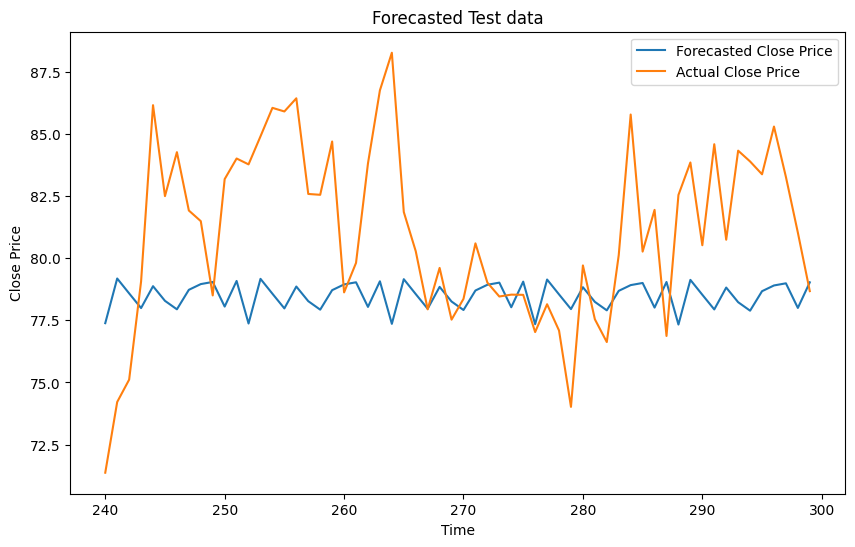

In [50]:
# plot forecasted vs actual close price

plt.figure(figsize=(10, 6))

plt.plot(X_validation['id'], forecasted_close, label='Forecasted Close Price')
plt.plot(X_validation['id'], Y_validation['Close'], label='Actual Close Price')

plt.title("Forecasted Test data")

plt.xlabel('Time')
plt.ylabel('Close Price')

plt.legend()

plt.show()


In [51]:
print('Mean Squared Error:', mean_squared_error(X_validation['Close'], forecasted_close))
print('Mean Absolute Error:', mean_absolute_error(X_validation['Close'], forecasted_close))
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(X_validation['Close'], forecasted_close))
print(f"Root Mean Squared Error (RMSE): {rmse}")




Mean Squared Error: 19.398385291307026
Mean Absolute Error: 3.5286788741035964
Root Mean Squared Error (RMSE): 4.404359804932724
